### Create dataset

SST-5 Dataset

In [2]:
import pandas as pd
import os

# Load datasets with proper paths
sst_train = pd.read_csv('SST-5 dataset/sst_train.txt', sep='\t', header=None, names=['label', 'text'], on_bad_lines='warn') # on_bad_lines='warn' to handle any malformed entries
sst_dev = pd.read_csv('SST-5 dataset/sst_dev.txt', sep='\t', header=None, names=['label', 'text'], on_bad_lines='warn')
sst_test = pd.read_csv('SST-5 dataset/sst_test.txt', sep='\t', header=None, names=['label', 'text'], on_bad_lines='warn')

# Combine dev and test into validation set
sst_val = pd.concat([sst_dev, sst_test], ignore_index=True)

# Create label mapping dictionary
label_mapping = {
    '__label__1': 0,  # Negative
    '__label__2': 0,  # Negative
    '__label__3': 1,  # Neutral
    '__label__4': 2,  # Positive
    '__label__5': 2   # Positive
}

# Apply label mapping
sst_train['label'] = sst_train['label'].map(label_mapping)
sst_val['label'] = sst_val['label'].map(label_mapping)

# Verify results
print("\nTraining set sample:")
print(sst_train.head())
print("\nValidation set sample:")
print(sst_val.head())
print("\nLabel distribution:")
print("Train:", sst_train['label'].value_counts())
print("Val:", sst_val['label'].value_counts())


Training set sample:
   label                                               text
0      2  The Rock is destined to be the 21st Century 's...
1      2  The gorgeously elaborate continuation of `` Th...
2      2  Singer/composer Bryan Adams contributes a slew...
3      1  You 'd think by now America would have had eno...
4      2               Yet the act is still charming here .

Validation set sample:
   label                                               text
0      2  It 's a lovely film with lovely performances b...
1      1  No one goes unindicted here , which is probabl...
2      2  And if you 're not nearly moved to tears by a ...
3      2                   A warm , funny , engaging film .
4      2  Uses sharp humor and insight into human nature...

Label distribution:
Train: label
2    3610
0    3310
1    1624
Name: count, dtype: int64
Val: label
2    1353
0    1340
1     618
Name: count, dtype: int64


Financial Phrasebank

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
fp_df = pd.read_csv('Financial Sentiment Analysis dataset/data.csv')

# Verify data structure
print("Original data sample:")
print(fp_df.head())
print("\nClass distribution:")
print(fp_df['Sentiment'].value_counts())

# Map sentiment labels
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
fp_df['Sentiment'] = fp_df['Sentiment'].str.lower().map(label_mapping)

# Stratified split
fp_df_train, fp_df_val = train_test_split(
    fp_df,
    test_size=0.3,
    stratify=fp_df['Sentiment'],
    random_state=42
)

# Save splits
fp_df_train.to_csv('Financial Sentiment Analysis dataset/fp_data_train.csv', index=False)
fp_df_val.to_csv('Financial Sentiment Analysis dataset/fp_data_validation.csv', index=False)

# Verification
print("\nTraining set distribution:")
print(fp_df_train['Sentiment'].value_counts())
print("\nValidation set distribution:")
print(fp_df_val['Sentiment'].value_counts())

Original data sample:
                                            Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral

Class distribution:
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

Training set distribution:
Sentiment
1    2191
2    1296
0     602
Name: count, dtype: int64

Validation set distribution:
Sentiment
1    939
2    556
0    258
Name: count, dtype: int64


In [13]:
# Rename columns to match 
fp_df_train = fp_df_train.rename(columns={'Sentence': 'text', 'Sentiment': 'label'})
fp_df_val = fp_df_val.rename(columns={'Sentence': 'text', 'Sentiment': 'label'})

# Verification
print("\nTraining set distribution:")
print(fp_df_train['label'].value_counts())
print("\nValidation set distribution:")
print(fp_df_val['label'].value_counts())


Training set distribution:
label
1    2191
2    1296
0     602
Name: count, dtype: int64

Validation set distribution:
label
1    939
2    556
0    258
Name: count, dtype: int64


Combine datasets

In [14]:
combined_train_data = pd.concat([sst_train, fp_df_train], ignore_index=True)
combined_val_data = pd.concat([sst_val, fp_df_val], ignore_index=True)

# Verification
print("\nCombined training set distribution:")
print(combined_train_data['label'].value_counts())
print("\nCombined validation set distribution:")
print(combined_val_data['label'].value_counts())


Combined training set distribution:
label
2    4906
0    3912
1    3815
Name: count, dtype: int64

Combined validation set distribution:
label
2    1909
0    1598
1    1557
Name: count, dtype: int64


Text cleaning and microtext normalisation

In [ ]:
import re

processed_train_df = combined_train_data
processed_val_df = combined_val_data

# Convert all text entries to strings and replace missing values
processed_train_df['text'] = processed_train_df['text'].astype(str).replace('nan', '')
processed_val_df['text'] = processed_val_df['text'].astype(str).replace('nan', '')

def clean_text(text):
    if not isinstance(text, str) or text.strip() == '':
        return ''
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)  # Remove URLs, mentions, hashtags
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)     # Remove special characters
    return text.strip()

# Apply to both training and validation sets
processed_train_df['Cleaned_Text'] = processed_train_df['text'].apply(clean_text)
processed_val_df['Cleaned_Text'] = processed_val_df['text'].apply(clean_text)

# Create domain-agnostic normalization dictionary
GENERAL_NORM_DICT = {
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bgr8\b": "great",
    r"\bb4\b": "before",
    r"\b2moro\b": "tomorrow",
    r"\bpls\b": "please",
    r"\bit's\b": "it is",
    r"\btbh\b": "to be honest",
    r"\bimo\b": "in my opinion"
}

def normalize_microtext(text):
    """Replace abbreviations and slang with full forms"""
    for pattern, replacement in GENERAL_NORM_DICT.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    return text

# Apply general normalization
processed_train_df['Normalized_Text'] = processed_train_df['Cleaned_Text'].apply(normalize_microtext)
processed_val_df['Normalized_Text'] = processed_val_df['Cleaned_Text'].apply(normalize_microtext)

processed_train_df.to_csv("processed_train_data.csv", index=False)
processed_val_df.to_csv("processed_val_data.csv", index=False)

## Train RoBERTa on public dataset

### Load and prepare data

In [3]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn 
from sklearn.utils import shuffle

# Prepare data for Pytorch
def prepare_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    return TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels)
    )

processed_train_df = pd.read_csv("processed_train_data.csv")
processed_val_df = pd.read_csv("processed_val_data.csv")

subj_train_texts = processed_train_df['Normalized_Text'].tolist()
train_labels = processed_train_df['label'].tolist()
subj_val_texts = processed_val_df['Normalized_Text'].tolist()
val_labels = processed_val_df['label'].tolist()

# Convert 3-class labels to binary (neutral=0, opinionated=1)
subj_train_labels = [0 if label == 1 else 1 for label in train_labels]
subj_val_labels = [0 if label == 1 else 1 for label in val_labels]

subj_train_labels_np = np.array(subj_train_labels)

# Check GPU availability and define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Class Distribution: ")
print(pd.Series(subj_train_labels).value_counts())

subj_class_weights = compute_class_weight('balanced', classes=np.unique(subj_train_labels_np), y=subj_train_labels_np)
print(f"Subjectivity class weights: {subj_class_weights}")
subj_class_weights = torch.tensor(subj_class_weights, dtype=torch.float32).to(device)
subj_loss_fn = nn.CrossEntropyLoss(weight=subj_class_weights)

# Create PyTorch datasets
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
subj_train_dataset = prepare_data(subj_train_texts, subj_train_labels, tokenizer)
subj_val_dataset = prepare_data(subj_val_texts, subj_val_labels, tokenizer)

subj_train_loader = DataLoader(subj_train_dataset, batch_size=64, shuffle=True, pin_memory=True)
subj_val_loader = DataLoader(subj_val_dataset, batch_size=64, pin_memory=True)

Using device: cpu
Class Distribution: 
1    8818
0    3815
Name: count, dtype: int64
Subjectivity class weights: [1.65570118 0.71631889]


C:\Users\chuas\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chuas\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\chuas\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated an

In [9]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, RobertaConfig, AdamW, get_scheduler, pipeline

# Create custom configuration
config = RobertaConfig.from_pretrained(
    'roberta-base',
    num_labels=2,
    id2label={0: 'Neutral', 1: 'Opinionated'},
    label2id={'Neutral': 0, 'Opinionated': 1},
    dropout=0.5,  # General dropout
    attention_dropout=0.5,  # Specific to attention layers
)

# Initialize model with custom configuration
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    config=config
).to(device)

def predict_subjectivity(text, model, tokenizer, device):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)

    # Only high confidence are subjective
    if 0.3 < probs[0][1] < 0.7:  # Neutral zone
        return "neutral"
    else:
        return "subjective" if probs[0][1] > 0.7 else "neutral"

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# Training parameters
EPOCHS = 50
PATIENCE = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
best_metrics = {}

/venv/main/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
for epoch in range(EPOCHS):
    # Training Phase
    model.train()
    total_train_loss = 0
    subj_train_preds, subj_train_labels = [], []
    
    train_progress = tqdm(subj_train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=True)
    for batch in train_progress:
        optimizer.zero_grad()
        inputs = {
            'input_ids': batch[0].to(device),
            'attention_mask': batch[1].to(device),
            'labels': batch[2].to(device)
        }
        
        outputs = model(**inputs)
        # loss = outputs.loss
        logits = outputs.logits
        loss = subj_loss_fn(logits, inputs['labels'])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
        
        total_train_loss += loss.item()
        subj_train_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        subj_train_labels.extend(inputs['labels'].cpu().numpy())
        
        train_progress.set_postfix({'loss': loss.item()})
    
    avg_train_loss = total_train_loss / len(subj_train_loader)
    train_acc = accuracy_score(subj_train_labels, subj_train_preds)
    
    # Validation Phase
    model.eval()
    total_val_loss = 0
    subj_val_preds, subj_val_labels = [], []
    
    val_progress = tqdm(subj_val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=True)
    with torch.no_grad():
        for batch in val_progress:
            inputs = {
                'input_ids': batch[0].to(device),
                'attention_mask': batch[1].to(device),
                'labels': batch[2].to(device)
            }
            
            outputs = model(**inputs)
            loss = outputs.loss
            total_val_loss += loss.item()
            
            # Modified prediction with thresholding
            texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in inputs['input_ids']]
            batch_preds = [
                1 if predict_subjectivity(text, model, tokenizer, device) == 'subjective' else 0 
                for text in texts
            ]
            
            subj_val_preds.extend(batch_preds)
            subj_val_labels.extend(inputs['labels'].cpu().numpy())
            
            val_progress.set_postfix({'val_loss': loss.item()})
    
    avg_val_loss = total_val_loss / len(subj_val_loader)
    val_acc = accuracy_score(subj_val_labels, subj_val_preds)
    val_precision = precision_score(subj_val_labels, subj_val_preds, average='weighted', zero_division=0)
    val_recall = recall_score(subj_val_labels, subj_val_preds, average='weighted')
    val_f1 = f1_score(subj_val_labels, subj_val_preds, average='weighted')
    
    # Update scheduler
    # scheduler.step()
    # Log the current learning rate
    # print(f"Learning Rate: {scheduler.optimizer.param_groups[0]['lr']}")
    
    # Print metrics
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    print(f"Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1-Score: {val_f1:.4f}")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        print(f"Validation loss improved {best_val_loss:.4f} → {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()
        best_metrics = {
            'epoch': epoch+1,
            'train_loss': avg_train_loss,
            'train_acc': train_acc,
            'val_loss': avg_val_loss,
            'val_acc': val_acc,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1
        }
        epochs_no_improve = 0
        # Save best model
        torch.save(best_model_state, './subj_roberta_best_model.pt')
        model.save_pretrained('./subj_roberta_best_model')
        tokenizer.save_pretrained('./subj_roberta_best_model')
    else:
        epochs_no_improve += 1
        print(f"Early stopping counter: {epochs_no_improve}/{PATIENCE}")
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

# After training completes
if best_model_state is not None:
    print("\n=== Best Model Performance ===")
    print(f"Best model from epoch {best_metrics['epoch']}:")
    print(f"Training Loss: {best_metrics['train_loss']:.4f} | Training Accuracy: {best_metrics['train_acc']:.4f}")
    print(f"Validation Loss: {best_metrics['val_loss']:.4f} | Validation Accuracy: {best_metrics['val_acc']:.4f}")
    print(f"Precision: {best_metrics['val_precision']:.4f} | Recall: {best_metrics['val_recall']:.4f} | F1-Score: {best_metrics['val_f1']:.4f}")
    
    # Save final model
    torch.save(model.state_dict(), './subj_roberta_final_model.pt')
    model.save_pretrained('./subj_roberta_final_model')
    tokenizer.save_pretrained('./subj_roberta_final_model')
    # Zip and download
    !zip -r subj_roberta_best_model.zip ./subj_roberta_best_model/
    !zip -r subj_roberta_final_model.zip ./subj_roberta_final_model/
    print("\nSaved both best and final models!")
else:
    print("No valid model saved during training")

Epoch 1/50 [Val]: 100%|██████████| 80/80 [00:46<00:00,  1.72it/s, val_loss=0.549]



Epoch 1/50
Training Loss: 0.5661 | Training Accuracy: 0.7365
Validation Loss: 0.4495 | Validation Accuracy: 0.6724
Precision: 0.7649 | Recall: 0.6724 | F1-Score: 0.6845
Validation loss improved inf → 0.4495. Saving model...


Epoch 2/50 [Val]: 100%|██████████| 80/80 [00:47<00:00,  1.70it/s, val_loss=0.421]



Epoch 2/50
Training Loss: 0.4608 | Training Accuracy: 0.7887
Validation Loss: 0.4306 | Validation Accuracy: 0.7281
Precision: 0.7811 | Recall: 0.7281 | F1-Score: 0.7383
Validation loss improved 0.4495 → 0.4306. Saving model...


Epoch 3/50 [Val]: 100%|██████████| 80/80 [00:47<00:00,  1.70it/s, val_loss=0.227]



Epoch 3/50
Training Loss: 0.4051 | Training Accuracy: 0.8068
Validation Loss: 0.4160 | Validation Accuracy: 0.7553
Precision: 0.7934 | Recall: 0.7553 | F1-Score: 0.7637
Validation loss improved 0.4306 → 0.4160. Saving model...


Epoch 4/50 [Val]: 100%|██████████| 80/80 [00:46<00:00,  1.71it/s, val_loss=0.185]



Epoch 4/50
Training Loss: 0.3623 | Training Accuracy: 0.8271
Validation Loss: 0.4356 | Validation Accuracy: 0.7727
Precision: 0.8001 | Recall: 0.7727 | F1-Score: 0.7795
Early stopping counter: 1/5


Epoch 5/50 [Val]: 100%|██████████| 80/80 [00:46<00:00,  1.71it/s, val_loss=0.221]



Epoch 5/50
Training Loss: 0.3263 | Training Accuracy: 0.8473
Validation Loss: 0.4545 | Validation Accuracy: 0.7861
Precision: 0.7995 | Recall: 0.7861 | F1-Score: 0.7905
Early stopping counter: 2/5


Epoch 6/50 [Val]: 100%|██████████| 80/80 [00:46<00:00,  1.71it/s, val_loss=0.167]



Epoch 6/50
Training Loss: 0.2781 | Training Accuracy: 0.8735
Validation Loss: 0.4929 | Validation Accuracy: 0.7662
Precision: 0.7876 | Recall: 0.7662 | F1-Score: 0.7723
Early stopping counter: 3/5


Epoch 7/50 [Val]: 100%|██████████| 80/80 [00:46<00:00,  1.71it/s, val_loss=0.193]



Epoch 7/50
Training Loss: 0.2333 | Training Accuracy: 0.8938
Validation Loss: 0.5944 | Validation Accuracy: 0.7769
Precision: 0.7976 | Recall: 0.7769 | F1-Score: 0.7827
Early stopping counter: 4/5


Epoch 8/50 [Val]: 100%|██████████| 80/80 [00:46<00:00,  1.70it/s, val_loss=0.171]



Epoch 8/50
Training Loss: 0.1932 | Training Accuracy: 0.9129
Validation Loss: 0.6095 | Validation Accuracy: 0.7824
Precision: 0.7909 | Recall: 0.7824 | F1-Score: 0.7856
Early stopping counter: 5/5

Early stopping at epoch 8

=== Best Model Performance ===
Best model from epoch 3:
Training Loss: 0.4051 | Training Accuracy: 0.8068
Validation Loss: 0.4160 | Validation Accuracy: 0.7553
Precision: 0.7934 | Recall: 0.7553 | F1-Score: 0.7637
  adding: subj_roberta_best_model/ (stored 0%)
  adding: subj_roberta_best_model/config.json (deflated 52%)
  adding: subj_roberta_best_model/model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 12%)
  adding: subj_roberta_best_model/tokenizer_config.json (deflated 76%)
  adding: subj_roberta_best_model/special_tokens_map.json (deflated 52%)
 (deflated 59%)roberta_best_model/vocab.json
 (deflated 53%)roberta_best_model/merges.txt
 (deflated 72%)roberta_best_model/tokenizer.json
  adding: subj_roberta_final_model/ (stored 0%)
  adding: subj_roberta_final_model/config.json (deflated 52%)
  adding: subj_roberta_final_model/model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 12%)
  adding: subj_roberta_final_model/tokenizer_config.json (deflated 76%)
  adding: subj_roberta_final_model/special_tokens_map.json (deflated 52%)
 (deflated 59%)roberta_final_model/vocab.json
 (deflated 53%)roberta_final_model/merges.txt
 (deflated 72%)roberta_final_model/tokenizer.json

Saved both best and final models!


Confusion matrix


Generating predictions for best model...


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [49:53<00:00, 37.41s/it]


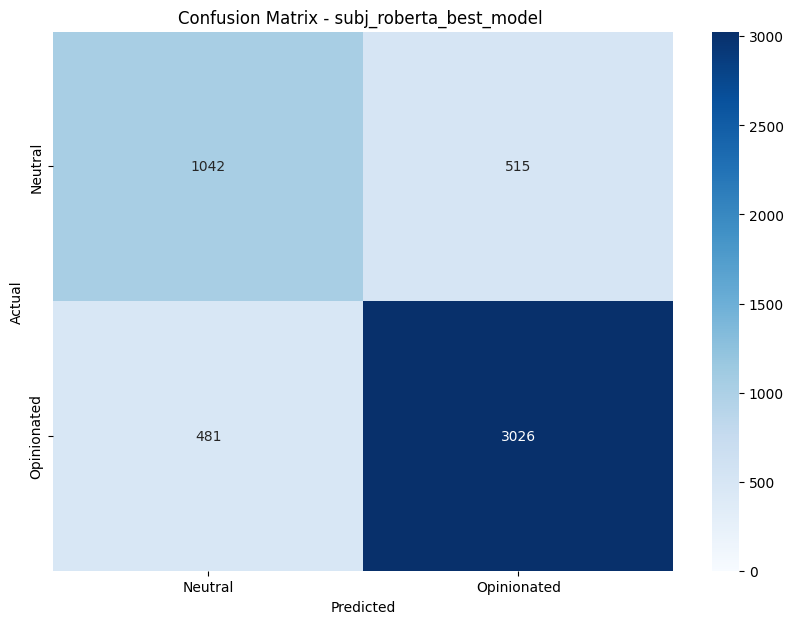

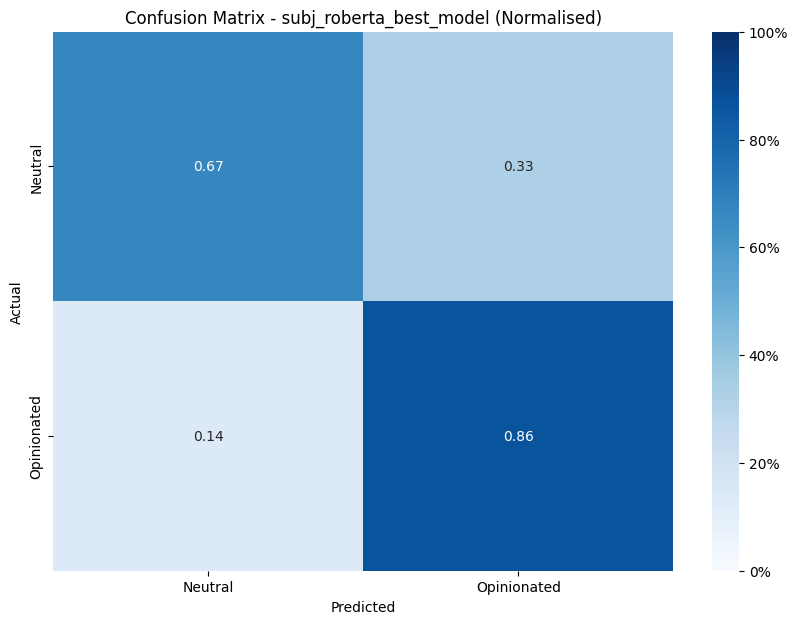


Metrics for Best Model:
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.68      0.67      0.68      1557
 Opinionated       0.85      0.86      0.86      3507

    accuracy                           0.80      5064
   macro avg       0.77      0.77      0.77      5064
weighted avg       0.80      0.80      0.80      5064

Accuracy: 0.8033175355450237
Precision: 0.7693684134989003
Recall: 0.7660407233976858
F1-Score: 0.7676533455194068

Generating predictions for final model...


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [45:42<00:00, 34.28s/it]


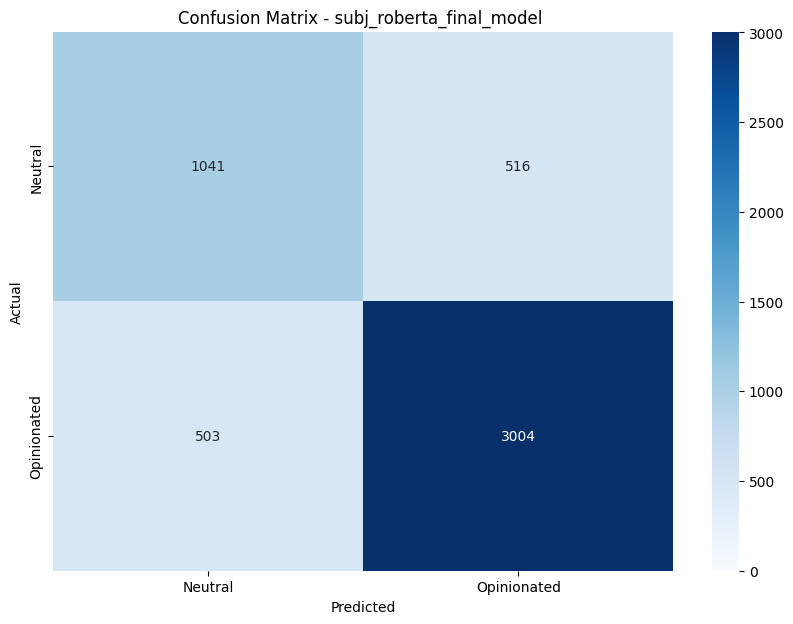

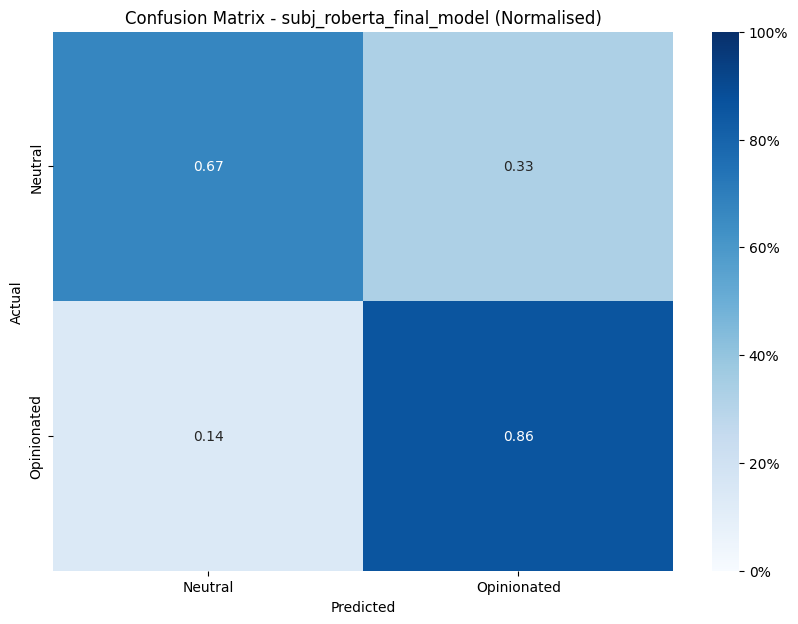


Metrics for Final Model:
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.67      0.67      0.67      1557
 Opinionated       0.85      0.86      0.85      3507

    accuracy                           0.80      5064
   macro avg       0.76      0.76      0.76      5064
weighted avg       0.80      0.80      0.80      5064

Accuracy: 0.7987756714060031
Precision: 0.7638159444182759
Recall: 0.7625830090438446
F1-Score: 0.7631921137830784


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

label_mapping = {'Neutral': 0, 'Opinionated': 1}

def plot_confusion_matrix(y_true, y_pred, model_name, normalize=True):
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        # Normalize by row (actual class)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'  # Show percentages
        title_suffix = '(Normalised)'
    else:
        fmt = 'd'    # Show raw counts
        title_suffix = ''
    
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt=fmt, 
                xticklabels=label_mapping.keys(),
                yticklabels=label_mapping.keys(),
                cmap='Blues', vmin=0, vmax=1 if normalize else None)
    plt.title(f'Confusion Matrix - {model_name} {title_suffix}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    # Add colorbar with percentage labels if normalized
    if normalize:
        cbar = plt.gca().collections[0].colorbar
        cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    
    plt.show()

# Load best model
subj_best_model = RobertaForSequenceClassification.from_pretrained('./subj_roberta_best_model').to(device)
subj_best_model.eval()

# Load final model
subj_final_model = RobertaForSequenceClassification.from_pretrained('./subj_roberta_final_model').to(device)
subj_final_model.eval()

def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs = {
                'input_ids': batch[0].to(device),
                'attention_mask': batch[1].to(device)
            }
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch[2].cpu().numpy())
            
    return all_labels, all_preds

# Get predictions
print("\nGenerating predictions for best model...")
subj_best_labels, subj_best_preds = get_predictions(subj_best_model, subj_val_loader)
plot_confusion_matrix(subj_best_labels, subj_best_preds, 'subj_roberta_best_model', normalize=False)
plot_confusion_matrix(subj_best_labels, subj_best_preds, 'subj_roberta_best_model', normalize=True)

# Calculate metrics for best model
print("\nMetrics for Best Model:")
print("Classification Report:")
print(classification_report(subj_best_labels, subj_best_preds, target_names=label_mapping.keys()))
print(f"Accuracy: {accuracy_score(subj_best_labels, subj_best_preds)}")
print(f"Precision: {precision_score(subj_best_labels, subj_best_preds, average='macro')}")
print(f"Recall: {recall_score(subj_best_labels, subj_best_preds, average='macro')}")
print(f"F1-Score: {f1_score(subj_best_labels, subj_best_preds, average='macro')}")

print("\nGenerating predictions for final model...")
subj_final_labels, subj_final_preds = get_predictions(subj_final_model, subj_val_loader)
plot_confusion_matrix(subj_final_labels, subj_final_preds, 'subj_roberta_final_model', normalize=False)
plot_confusion_matrix(subj_final_labels, subj_final_preds, 'subj_roberta_final_model', normalize=True)

# Calculate metrics for final model
print("\nMetrics for Final Model:")
print("Classification Report:")
print(classification_report(subj_final_labels, subj_final_preds, target_names=label_mapping.keys()))
print(f"Accuracy: {accuracy_score(subj_final_labels, subj_final_preds)}")
print(f"Precision: {precision_score(subj_final_labels, subj_final_preds, average='macro')}")
print(f"Recall: {recall_score(subj_final_labels, subj_final_preds, average='macro')}")
print(f"F1-Score: {f1_score(subj_final_labels, subj_final_preds, average='macro')}")

In [9]:
# Calculate metrics for best model
print("\nMetrics for Best Model:")
print("Classification Report:")
print(classification_report(subj_best_labels, subj_best_preds, target_names=label_mapping.keys()))
print(f"Accuracy: {accuracy_score(subj_best_labels, subj_best_preds)}")
print(f"Precision (macro): {precision_score(subj_best_labels, subj_best_preds, average='macro')}")
print(f"Recall (macro): {recall_score(subj_best_labels, subj_best_preds, average='macro')}")
print(f"F1-Score (macro): {f1_score(subj_best_labels, subj_best_preds, average='macro')}")
print(f"Precision (weighted): {precision_score(subj_best_labels, subj_best_preds, average='weighted')}")
print(f"Recall (weighted): {recall_score(subj_best_labels, subj_best_preds, average='weighted')}")
print(f"F1-Score (weighted): {f1_score(subj_best_labels, subj_best_preds, average='weighted')}")

# Calculate metrics for final model
print("\nMetrics for Final Model:")
print("Classification Report:")
print(classification_report(subj_final_labels, subj_final_preds, target_names=label_mapping.keys()))
print(f"Accuracy: {accuracy_score(subj_final_labels, subj_final_preds)}")
print(f"Precision (macro): {precision_score(subj_final_labels, subj_final_preds, average='macro')}")
print(f"Recall (macro): {recall_score(subj_final_labels, subj_final_preds, average='macro')}")
print(f"F1-Score (macro): {f1_score(subj_final_labels, subj_final_preds, average='macro')}")
print(f"Precision (weighted): {precision_score(subj_final_labels, subj_final_preds, average='weighted')}")
print(f"Recall (weighted): {recall_score(subj_final_labels, subj_final_preds, average='weighted')}")
print(f"F1-Score (weighted): {f1_score(subj_final_labels, subj_final_preds, average='weighted')}")


Metrics for Best Model:
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.68      0.67      0.68      1557
 Opinionated       0.85      0.86      0.86      3507

    accuracy                           0.80      5064
   macro avg       0.77      0.77      0.77      5064
weighted avg       0.80      0.80      0.80      5064

Accuracy: 0.8033175355450237
Precision (macro): 0.7693684134989003
Recall (macro): 0.7660407233976858
F1-Score (macro): 0.7676533455194068
Precision (weighted): 0.8021735611648768
Recall (weighted): 0.8033175355450237
F1-Score (weighted): 0.8027063548691815

Metrics for Final Model:
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.67      0.67      0.67      1557
 Opinionated       0.85      0.86      0.85      3507

    accuracy                           0.80      5064
   macro avg       0.76      0.76      0.76      5064
weighted avg       0.80      0.80      0.80   

### Polarity detection

In [8]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn 
from sklearn.utils import shuffle

# Prepare data for Pytorch
def prepare_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    return TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels)
    )

processed_train_df = pd.read_csv("processed_train_data.csv")
processed_val_df = pd.read_csv("processed_val_data.csv")

# Load data excluding neutrals (label=1)
polar_train_df = processed_train_df[processed_train_df['label'] != 1]
polar_val_df = processed_val_df[processed_val_df['label'] != 1]

# Convert to negative (0) and positive (2 → 1)
polar_train_labels = polar_train_df['label'].replace({2: 1}).tolist()
polar_val_labels = polar_val_df['label'].replace({2: 1}).tolist()

polar_train_labels_np = np.array(polar_train_labels)

# Check GPU availability and define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Class Distribution: ")
print(pd.Series(polar_train_labels).value_counts())

polar_class_weights = compute_class_weight('balanced', classes=np.unique(polar_train_labels_np), y=polar_train_labels_np)
print(f"Polarity class weights: {polar_class_weights}")
polar_class_weights = torch.tensor(polar_class_weights, dtype=torch.float32).to(device)
polar_loss_fn = nn.CrossEntropyLoss(weight=polar_class_weights)

# Create PyTorch datasets
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
polar_train_dataset = prepare_data(polar_train_df['Normalized_Text'].tolist(), polar_train_labels, tokenizer)
polar_val_dataset = prepare_data(polar_val_df['Normalized_Text'].tolist(), polar_val_labels, tokenizer)

polar_train_loader = DataLoader(polar_train_dataset, batch_size=64, shuffle=True, pin_memory=True)
polar_val_loader = DataLoader(polar_val_dataset, batch_size=64, pin_memory=True)

Using device: cpu
Class Distribution: 
1    4906
0    3912
Name: count, dtype: int64
Polarity class weights: [1.12704499 0.89869547]


In [4]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, RobertaConfig, AdamW, get_scheduler, pipeline

# Initialize polarity model
polar_config = RobertaConfig.from_pretrained(
    'roberta-base',
    num_labels=2,
    id2label={0: 'Negative', 1: 'Positive'},
    label2id={'Negative': 0, 'Positive': 1},
    dropout=0.5, 
    attention_dropout=0.5
)
polar_model = RobertaForSequenceClassification.from_pretrained('roberta-base', config=polar_config).to(device)

optimizer = torch.optim.AdamW(polar_model.parameters(), lr=1e-5, weight_decay=0.01)

# Training parameters
EPOCHS = 50
PATIENCE = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
best_metrics = {}

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
for epoch in range(EPOCHS):
    # Training Phase
    polar_model.train()
    total_train_loss = 0
    polar_train_preds, polar_train_labels = [], []
    
    train_progress = tqdm(polar_train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=True)
    for batch in train_progress:
        optimizer.zero_grad()
        # Modified input handling
        inputs = {
            'input_ids': batch[0].to(device),
            'attention_mask': batch[1].to(device),
            'labels': batch[2].to(device)
        }
        
        outputs = polar_model(**inputs)
        # loss = outputs.loss
        logits = outputs.logits
        loss = polar_loss_fn(logits, inputs['labels'])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(polar_model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
        
        total_train_loss += loss.item()
        polar_train_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        polar_train_labels.extend(inputs['labels'].cpu().numpy())
        
        train_progress.set_postfix({'loss': loss.item()})
    
    avg_train_loss = total_train_loss / len(polar_train_loader)
    train_acc = accuracy_score(polar_train_labels, polar_train_preds)
    
    # Validation Phase
    polar_model.eval()
    total_val_loss = 0
    polar_val_preds, polar_val_labels = [], []
    
    val_progress = tqdm(polar_val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=True)
    with torch.no_grad():
        for batch in val_progress:
            inputs = {
                'input_ids': batch[0].to(device),
                'attention_mask': batch[1].to(device),
                'labels': batch[2].to(device)
            }
            
            outputs = polar_model(**inputs)
            loss = outputs.loss
            total_val_loss += loss.item()
            
            # Single prediction method
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = inputs['labels'].cpu().numpy()
            
            polar_val_preds.extend(preds)
            polar_val_labels.extend(labels)
            
            val_progress.set_postfix({'val_loss': loss.item()})
    
    avg_val_loss = total_val_loss / len(polar_val_loader)
    val_acc = accuracy_score(polar_val_labels, polar_val_preds)
    val_precision = precision_score(polar_val_labels, polar_val_preds, average='weighted', zero_division=0)
    val_recall = recall_score(polar_val_labels, polar_val_preds, average='weighted')
    val_f1 = f1_score(polar_val_labels, polar_val_preds, average='weighted')
    
    # Print metrics
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    print(f"Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1-Score: {val_f1:.4f}")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        print(f"Validation loss improved {best_val_loss:.4f} → {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        best_model_state = polar_model.state_dict().copy()
        best_metrics = {
            'epoch': epoch+1,
            'train_loss': avg_train_loss,
            'train_acc': train_acc,
            'val_loss': avg_val_loss,
            'val_acc': val_acc,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1
        }
        epochs_no_improve = 0
        # Save best model
        torch.save(best_model_state, './polar_roberta_best_model.pt')
        polar_model.save_pretrained('./polar_roberta_best_model')
        tokenizer.save_pretrained('./polar_roberta_best_model')
    else:
        epochs_no_improve += 1
        print(f"Early stopping counter: {epochs_no_improve}/{PATIENCE}")
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

# After training completes
if best_model_state is not None:
    print("\n=== Best Model Performance ===")
    print(f"Best model from epoch {best_metrics['epoch']}:")
    print(f"Training Loss: {best_metrics['train_loss']:.4f} | Training Accuracy: {best_metrics['train_acc']:.4f}")
    print(f"Validation Loss: {best_metrics['val_loss']:.4f} | Validation Accuracy: {best_metrics['val_acc']:.4f}")
    print(f"Precision: {best_metrics['val_precision']:.4f} | Recall: {best_metrics['val_recall']:.4f} | F1-Score: {best_metrics['val_f1']:.4f}")
    
    # Save final model
    torch.save(polar_model.state_dict(), './polar_roberta_final_model.pt')
    polar_model.save_pretrained('./polar_roberta_final_model')
    tokenizer.save_pretrained('./polar_roberta_final_model')
    # Zip and download
    !zip -r polar_roberta_best_model.zip ./polar_roberta_best_model/
    !zip -r polar_roberta_final_model.zip ./polar_roberta_final_model/
    print("\nSaved both best and final models!")
else:
    print("No valid model saved during training")

Epoch 1/50 [Val]: 100%|██████████| 55/55 [00:05<00:00, 10.38it/s, val_loss=0.158] 



Epoch 1/50
Training Loss: 0.4057 | Training Accuracy: 0.7977
Validation Loss: 0.2090 | Validation Accuracy: 0.9199
Precision: 0.9205 | Recall: 0.9199 | F1-Score: 0.9200
Validation loss improved inf → 0.2090. Saving model...


Epoch 2/50 [Val]: 100%|██████████| 55/55 [00:05<00:00, 10.32it/s, val_loss=0.142] 



Epoch 2/50
Training Loss: 0.1929 | Training Accuracy: 0.9303
Validation Loss: 0.1927 | Validation Accuracy: 0.9341
Precision: 0.9341 | Recall: 0.9341 | F1-Score: 0.9341
Validation loss improved 0.2090 → 0.1927. Saving model...


Epoch 3/50 [Val]: 100%|██████████| 55/55 [00:05<00:00, 10.22it/s, val_loss=0.172] 



Epoch 3/50
Training Loss: 0.1338 | Training Accuracy: 0.9532
Validation Loss: 0.2112 | Validation Accuracy: 0.9358
Precision: 0.9359 | Recall: 0.9358 | F1-Score: 0.9358
Early stopping counter: 1/5


Epoch 4/50 [Val]: 100%|██████████| 55/55 [00:05<00:00, 10.25it/s, val_loss=0.146] 



Epoch 4/50
Training Loss: 0.0940 | Training Accuracy: 0.9681
Validation Loss: 0.2392 | Validation Accuracy: 0.9344
Precision: 0.9359 | Recall: 0.9344 | F1-Score: 0.9342
Early stopping counter: 2/5


Epoch 5/50 [Val]: 100%|██████████| 55/55 [00:05<00:00, 10.26it/s, val_loss=0.171]  



Epoch 5/50
Training Loss: 0.0729 | Training Accuracy: 0.9772
Validation Loss: 0.3011 | Validation Accuracy: 0.9307
Precision: 0.9314 | Recall: 0.9307 | F1-Score: 0.9305
Early stopping counter: 3/5


Epoch 6/50 [Val]: 100%|██████████| 55/55 [00:05<00:00, 10.27it/s, val_loss=0.271]  



Epoch 6/50
Training Loss: 0.0576 | Training Accuracy: 0.9849
Validation Loss: 0.3200 | Validation Accuracy: 0.9319
Precision: 0.9327 | Recall: 0.9319 | F1-Score: 0.9317
Early stopping counter: 4/5


Epoch 7/50 [Val]: 100%|██████████| 55/55 [00:05<00:00, 10.25it/s, val_loss=0.2]   



Epoch 7/50
Training Loss: 0.0442 | Training Accuracy: 0.9887
Validation Loss: 0.3165 | Validation Accuracy: 0.9384
Precision: 0.9384 | Recall: 0.9384 | F1-Score: 0.9384
Early stopping counter: 5/5

Early stopping at epoch 7

=== Best Model Performance ===
Best model from epoch 2:
Training Loss: 0.1929 | Training Accuracy: 0.9303
Validation Loss: 0.1927 | Validation Accuracy: 0.9341
Precision: 0.9341 | Recall: 0.9341 | F1-Score: 0.9341
  adding: polar_roberta_best_model/ (stored 0%)
  adding: polar_roberta_best_model/config.json (deflated 52%)
  adding: polar_roberta_best_model/model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 12%)
  adding: polar_roberta_best_model/tokenizer_config.json (deflated 76%)
  adding: polar_roberta_best_model/special_tokens_map.json (deflated 52%)
 (deflated 59%)_roberta_best_model/vocab.json
 (deflated 53%)_roberta_best_model/merges.txt
 (deflated 72%)_roberta_best_model/tokenizer.json
  adding: polar_roberta_final_model/ (stored 0%)
  adding: polar_roberta_final_model/config.json (deflated 52%)
  adding: polar_roberta_final_model/model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 12%)
  adding: polar_roberta_final_model/tokenizer_config.json (deflated 76%)
  adding: polar_roberta_final_model/special_tokens_map.json (deflated 52%)
 (deflated 59%)_roberta_final_model/vocab.json
 (deflated 53%)_roberta_final_model/merges.txt
 (deflated 72%)_roberta_final_model/tokenizer.json

Saved both best and final models!


Confusion matrix


Generating predictions for best model...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [33:05<00:00, 36.10s/it]


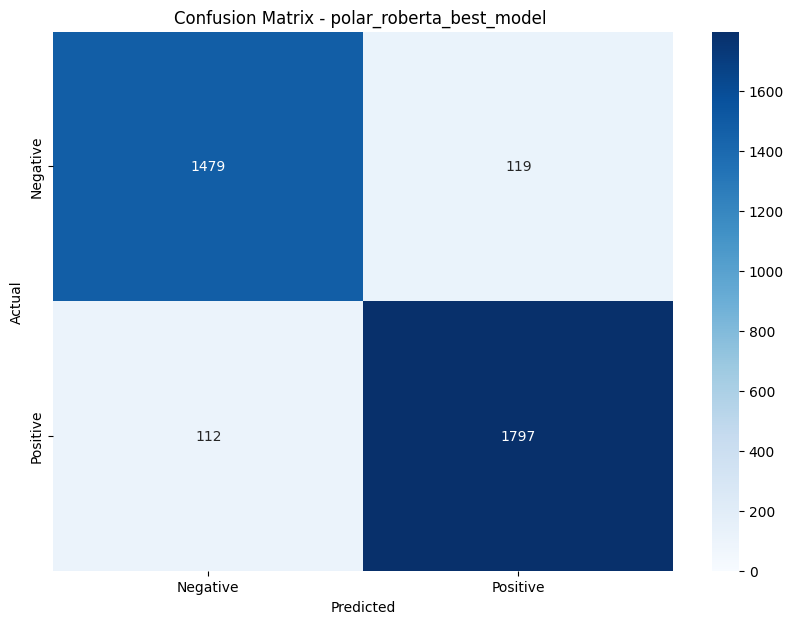

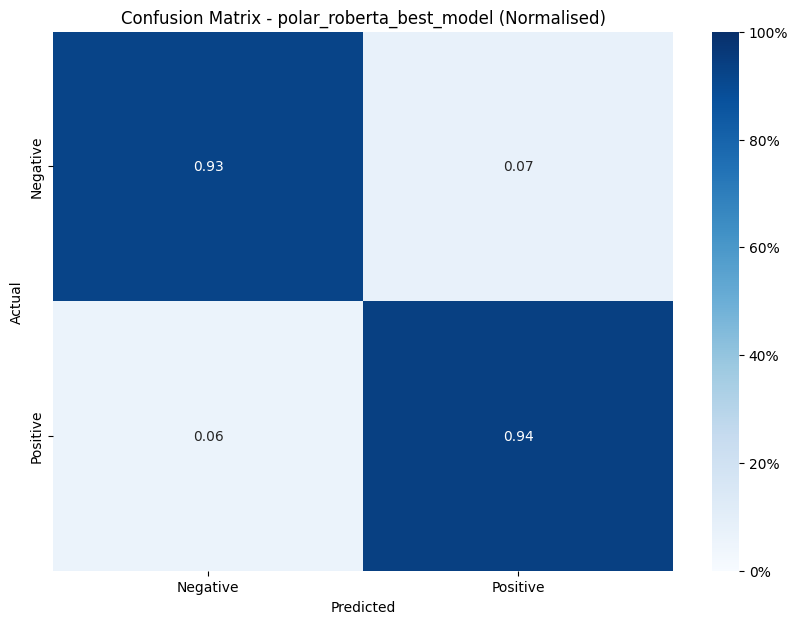


Metrics for Best Model:
Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.93      0.93      1598
    Positive       0.94      0.94      0.94      1909

    accuracy                           0.93      3507
   macro avg       0.93      0.93      0.93      3507
weighted avg       0.93      0.93      0.93      3507

Accuracy: 0.9341317365269461
Precision (macro): 0.9337477315641611
Recall (macro): 0.9334312272215597
F1-Score (macro): 0.9335856713334441
Precision (weighted): 0.9341151947747031
Recall (weighted): 0.9341317365269461
F1-Score (weighted): 0.9341197162239445

Generating predictions for final model...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [31:30<00:00, 34.36s/it]


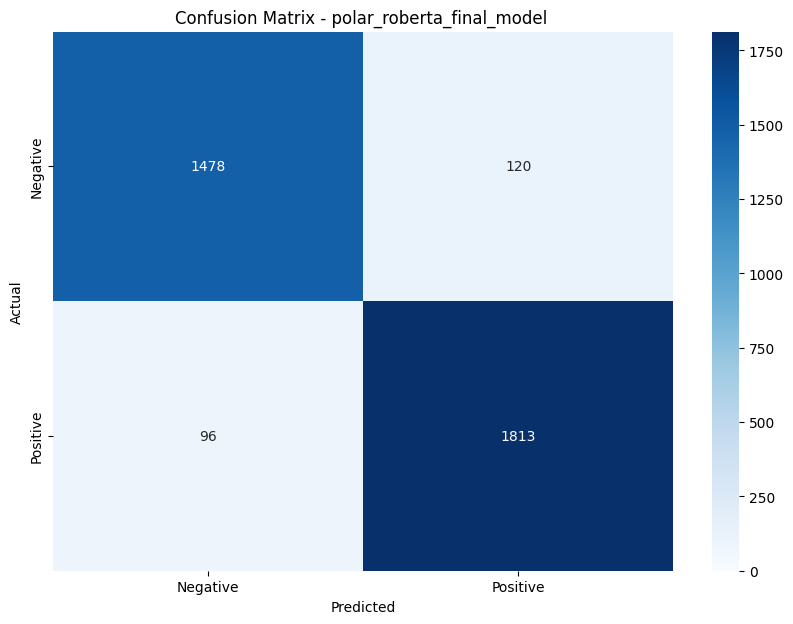

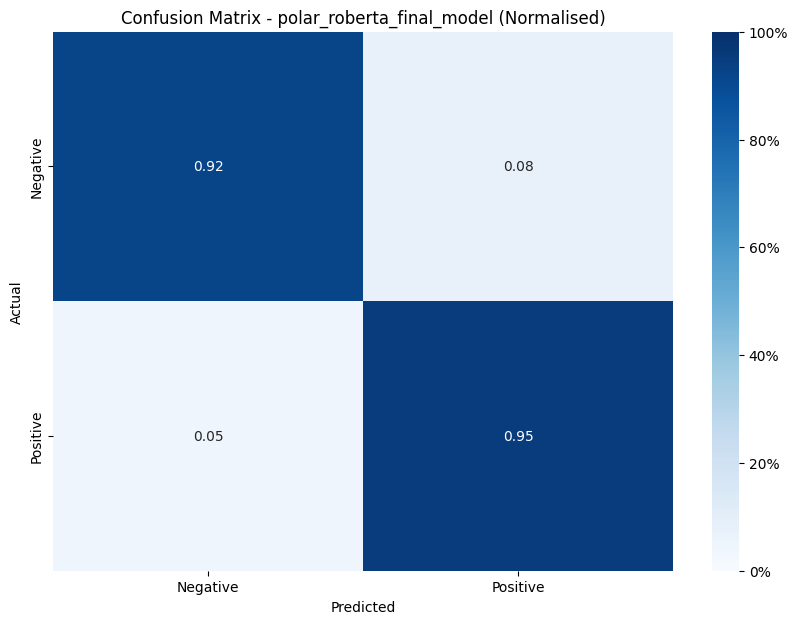


Metrics for Final Model:
Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.92      0.93      1598
    Positive       0.94      0.95      0.94      1909

    accuracy                           0.94      3507
   macro avg       0.94      0.94      0.94      3507
weighted avg       0.94      0.94      0.94      3507

Accuracy: 0.9384088964927289
Precision (macro): 0.9384646128138905
Recall (macro): 0.9373090118541314
F1-Score (macro): 0.9378417215182561
Precision (weighted): 0.9384163460287058
Recall (weighted): 0.9384088964927289
F1-Score (weighted): 0.9383682630617217


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

label_mapping = {'Negative': 0, 'Positive': 1}

def plot_confusion_matrix(y_true, y_pred, model_name, normalize=True):
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        # Normalize by row (actual class)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'  # Show percentages
        title_suffix = '(Normalised)'
    else:
        fmt = 'd'    # Show raw counts
        title_suffix = ''
    
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt=fmt, 
                xticklabels=label_mapping.keys(),
                yticklabels=label_mapping.keys(),
                cmap='Blues', vmin=0, vmax=1 if normalize else None)
    plt.title(f'Confusion Matrix - {model_name} {title_suffix}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    # Add colorbar with percentage labels if normalized
    if normalize:
        cbar = plt.gca().collections[0].colorbar
        cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    
    plt.show()

# Load best model
polar_best_model = RobertaForSequenceClassification.from_pretrained('./polar_roberta_best_model').to(device)
polar_best_model.eval()

# Load final model
polar_final_model = RobertaForSequenceClassification.from_pretrained('./polar_roberta_final_model').to(device)
polar_final_model.eval()

def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs = {
                'input_ids': batch[0].to(device),
                'attention_mask': batch[1].to(device)
            }
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch[2].cpu().numpy())
            
    return all_labels, all_preds

# Get predictions
print("\nGenerating predictions for best model...")
polar_best_labels, polar_best_preds = get_predictions(polar_best_model, polar_val_loader)
plot_confusion_matrix(polar_best_labels, polar_best_preds, 'polar_roberta_best_model', normalize=False)
plot_confusion_matrix(polar_best_labels, polar_best_preds, 'polar_roberta_best_model', normalize=True)

# Calculate metrics for best model
print("\nMetrics for Best Model:")
print("Classification Report:")
print(classification_report(polar_best_labels, polar_best_preds, target_names=label_mapping.keys()))
print(f"Accuracy: {accuracy_score(polar_best_labels, polar_best_preds)}")
print(f"Precision (macro): {precision_score(polar_best_labels, polar_best_preds, average='macro')}")
print(f"Recall (macro): {recall_score(polar_best_labels, polar_best_preds, average='macro')}")
print(f"F1-Score (macro): {f1_score(polar_best_labels, polar_best_preds, average='macro')}")
print(f"Precision (weighted): {precision_score(polar_best_labels, polar_best_preds, average='weighted')}")
print(f"Recall (weighted): {recall_score(polar_best_labels, polar_best_preds, average='weighted')}")
print(f"F1-Score (weighted): {f1_score(polar_best_labels, polar_best_preds, average='weighted')}")

print("\nGenerating predictions for final model...")
polar_final_labels, polar_final_preds = get_predictions(polar_final_model, polar_val_loader)
plot_confusion_matrix(polar_final_labels, polar_final_preds, 'polar_roberta_final_model', normalize=False)
plot_confusion_matrix(polar_final_labels, polar_final_preds, 'polar_roberta_final_model', normalize=True)

# Calculate metrics for final model
print("\nMetrics for Final Model:")
print("Classification Report:")
print(classification_report(polar_final_labels, polar_final_preds, target_names=label_mapping.keys()))
print(f"Accuracy: {accuracy_score(polar_final_labels, polar_final_preds)}")
print(f"Precision (macro): {precision_score(polar_final_labels, polar_final_preds, average='macro')}")
print(f"Recall (macro): {recall_score(polar_final_labels, polar_final_preds, average='macro')}")
print(f"F1-Score (macro): {f1_score(polar_final_labels, polar_final_preds, average='macro')}")
print(f"Precision (weighted): {precision_score(polar_final_labels, polar_final_preds, average='weighted')}")
print(f"Recall (weighted): {recall_score(polar_final_labels, polar_final_preds, average='weighted')}")
print(f"F1-Score (weighted): {f1_score(polar_final_labels, polar_final_preds, average='weighted')}")

## Combined prediction

In [ ]:
import zipfile

# Path to the uploaded zip file
zip_file_path = "subj_roberta_final_model.zip"

# Directory where you want to extract the files
extract_to = "/"

# Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")

# Extracting the zip file
with zipfile.ZipFile("polar_roberta_final_model.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, RobertaConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

### Microtext Normalisation on eval_comparison dataset

In [3]:
import re

# Microtext normalization dictionary (expand with more EV-specific terms)
MICROTEXT_DICT = {
    r"\bEVs?\b": "Electric Vehicle",
    r"\bICE\b": "Internal Combustion Engine",
    r"\bLiIon\b": "Lithium-Ion",
    r"\bTesla\b": "Tesla",
    r"\bNio\b": "NIO",
    r"\bBaaS\b": "Battery as a Service",
    r"\bSoC\b": "State of Charge",
    r"\bSOC\b": "State of Charge",  # Case-sensitive fix
    r"\bDC\b": "Direct Current",
    r"\bAC\b": "Alternating Current",
    r"\bV2G\b": "Vehicle-to-Grid",
    r"\bBEV\b": "Battery Electric Vehicle",
    r"\bPHEV\b": "Plug-in Hybrid Electric Vehicle",
    r"\bHEV\b": "Hybrid Electric Vehicle",
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bgr8\b": "great",
    r"\bb4\b": "before",
    r"\bpls\b": "please",
    r"\bSC\b": "Supercharger",
    r"\bDCFC\b": "DC Fast Charging",
    r"\bLFP\b": "Lithium Iron Phosphate",
    r"\btbh\b": "to be honest",
    r"\bimo\b": "in my opinion"
}

def clean_text(text):
    text = re.sub(r"http\S+|@\w+", "", text)  
    text = re.sub(r"#(\w+)", r"\1", text)  
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)    
    return text.strip()

def normalise_microtext(text):
    for pattern, replacement in MICROTEXT_DICT.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    return text

# Load dataset and apply cleaning and normalisation
eval_df = pd.read_excel('eval_comparison.xlsx')
# Convert all text entries to strings and replace missing values
# eval_df['combined_text'] = eval_df['combined_text'].astype(str).replace('nan', '')
eval_df['comment_content'] = eval_df['comment_content'].astype(str).replace('nan', '')
eval_df['Cleaned_Text'] = eval_df['comment_content'].apply(clean_text)
eval_df['Normalised_Text'] = eval_df['Cleaned_Text'].apply(normalise_microtext)
eval_df.to_excel("processed_eval_comparison_updated.xlsx", index=False)

### Combined prediction using both trained models

### Evaluation metrics on 1000 labelled dataset

In [7]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, RobertaConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import time 

In [2]:
# Prepare data for Pytorch
def prepare_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    return TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels)
    )

def analyse_sentiment(texts, subj_model, polar_model, tokenizer, device, batch_size=64):
    start_time = time.time()
    """Two-stage sentiment analysis pipeline"""
    # Stage 1: Subjectivity filtering
    subj_probs = []
    subj_dataset = prepare_data(texts, [0]*len(texts), tokenizer)
    subj_loader = DataLoader(subj_dataset, batch_size=batch_size)
    
    all_subj_preds = []
    subj_model.eval()
    with torch.no_grad():
        # for i, batch in enumerate(subj_loader):
        for batch in subj_loader:
            # print(f"Processing batch {i+1}/{len(subj_loader)}")
            inputs = {
                'input_ids': batch[0].to(device),
                'attention_mask': batch[1].to(device)
            }
            outputs = subj_model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)
            batch_preds = ['subjective' if p[1] > 0.2 else 'neutral' for p in probs] # classifies 522 as subjective (instead of 543) 
            all_subj_preds.extend(batch_preds)


    # Number of subjective texts identified after Stage 1
    polar_texts = [text for text, pred in zip(texts, all_subj_preds) if pred == 'subjective']
    print(f"\nSubjects classified as 'subjective': {len(polar_texts)}/{len(texts)}")
    
    # Stage 2: Polarity classification
    polar_preds = []
    if polar_texts:
        polar_dataset = prepare_data(polar_texts, [0]*len(polar_texts), tokenizer)
        polar_loader = DataLoader(polar_dataset, batch_size=batch_size)
        
        polar_model.eval()
        with torch.no_grad():
            # for i, batch in enumerate(polar_loader):
            for batch in polar_loader:
                # print(f"Processing polarity batch {i+1}/{len(polar_loader)}")
                inputs = {
                    'input_ids': batch[0].to(device),
                    'attention_mask': batch[1].to(device)
                }
                outputs = polar_model(**inputs)
                batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy().tolist()
                polar_preds.extend(['positive' if p == 1 else 'negative' for p in batch_preds])

    # Combine results
    results = []
    polar_idx = 0
    for text, subj_pred in zip(texts, all_subj_preds):
        if subj_pred == 'neutral':
            results.append({'text': text, 'sentiment': 'neutral'})
        else:
            if polar_idx < len(polar_preds):
                results.append({'text': text, 'sentiment': polar_preds[polar_idx]})
                polar_idx += 1
            else:
                results.append({'text': text, 'sentiment': 'neutral'})
            
    # Create DataFrame with original texts and predictions
    results_df = pd.DataFrame(results)

    end_time = time.time()
    duration_ms = (end_time - start_time) * 1000  # Convert to milliseconds
    
    return results, results_df, duration_ms  # Return raw results, DataFrame, and duration

In [3]:
import zipfile

# Path to the uploaded zip file
zip_file_path = "subj_roberta_final_model.zip"

# Directory where you want to extract the files
extract_to = "/basher"

# Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")

# Extracting the zip file
with zipfile.ZipFile("polar_roberta_final_model.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")

Files extracted to: /basher
Files extracted to: /basher


In [4]:
# Load models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
subj_model = RobertaForSequenceClassification.from_pretrained('./subj_roberta_final_model').to(device)
polar_model = RobertaForSequenceClassification.from_pretrained('./polar_roberta_final_model').to(device)
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/venv/main/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [8]:
# 1. Load and filter data
processed_eval_df = pd.read_excel('processed_eval_comparison_updated.xlsx')
valid_labels = ['Negative', 'Neutral', 'Positive']
# filtered_df = processed_eval_df[processed_eval_df['final_label'].isin(valid_labels)].copy()

# 2. Get predictions
texts = processed_eval_df['Normalised_Text'].astype(str).fillna('').tolist()  # Force string conversion

# Remove empty strings and whitespace-only texts
texts = [t.strip() for t in texts if t.strip()]
predictions, predictions_df, duration_ms = analyse_sentiment(texts, subj_model, polar_model, tokenizer, device)
print(f"\nTotal prediction time: {duration_ms:.4f} ms")

# 3. Align predictions with ground truth
predicted_labels = [pred['sentiment'].capitalize() for pred in predictions]  # Match case
true_labels = processed_eval_df['final_label'].tolist()

# 4. Calculate metrics with per-class breakdown
labels = ['Negative', 'Neutral', 'Positive']

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None, labels=labels, zero_division=0)
recall = recall_score(true_labels, predicted_labels, average=None, labels=labels, zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average=None, labels=labels, zero_division=0)

# Print overall metrics
print(f"Validation Accuracy: {accuracy:.6f}")
print("\nPer-class Metrics:")
for i, label in enumerate(labels):
    print(f"\n{label}:")
    print(f"  Precision: {precision[i]:.6f}")
    print(f"  Recall:    {recall[i]:.6f}")
    print(f"  F1-Score:  {f1[i]:.6f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, labels=labels, zero_division=0))


Subjects classified as 'subjective': 589/1000

Total prediction time: 2731.9496 ms
Validation Accuracy: 0.678000

Per-class Metrics:

Negative:
  Precision: 0.715762
  Recall:    0.670702
  F1-Score:  0.692500

Neutral:
  Precision: 0.652068
  Recall:    0.690722
  F1-Score:  0.670839

Positive:
  Precision: 0.658416
  Recall:    0.675127
  F1-Score:  0.666667

Classification Report:
              precision    recall  f1-score   support

    Negative       0.72      0.67      0.69       413
     Neutral       0.65      0.69      0.67       388
    Positive       0.66      0.68      0.67       197

   micro avg       0.68      0.68      0.68       998
   macro avg       0.68      0.68      0.68       998
weighted avg       0.68      0.68      0.68       998



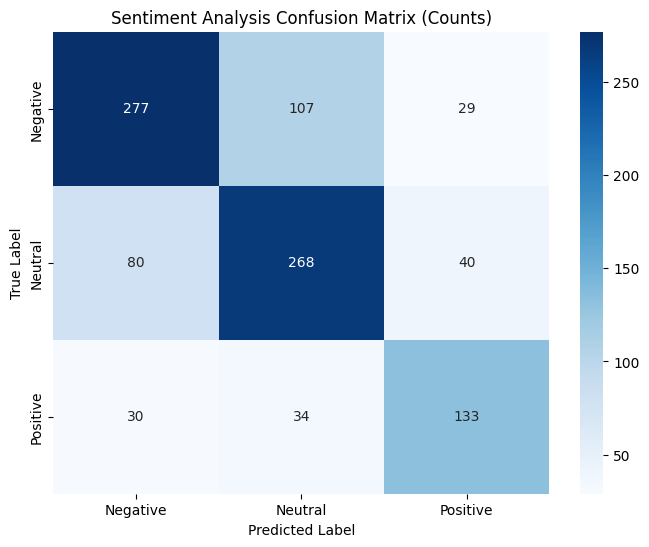

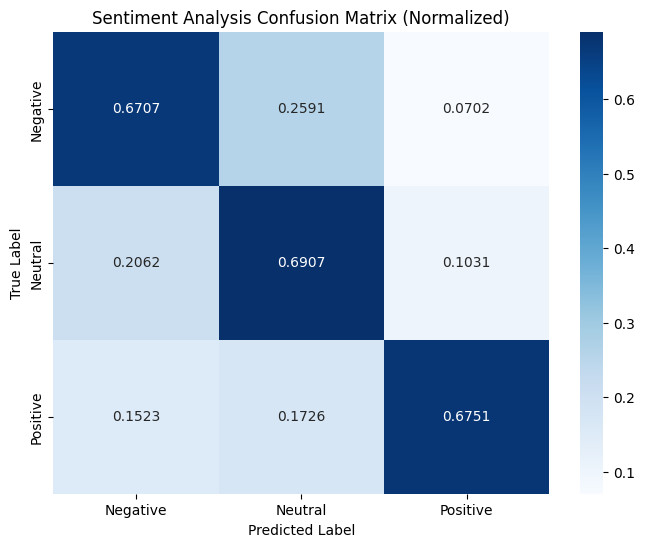

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate and plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', normalize=False):
    """
    Plots confusion matrix with optional normalization
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.4f'
        title += ' (Normalized)'
    else:
        fmt = 'd'
        title += ' (Counts)'

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(true_labels, predicted_labels, classes=labels, title='Sentiment Analysis Confusion Matrix', normalize=False)
plot_confusion_matrix(true_labels, predicted_labels, classes=labels, title='Sentiment Analysis Confusion Matrix', normalize=True)

## Microtext Normalisation on main dataset

In [79]:
import re

# Microtext normalisation dictionary (expand with more EV-specific terms)
MICROTEXT_DICT = {
    r"\bEVs?\b": "Electric Vehicle",
    r"\bICE\b": "Internal Combustion Engine",
    r"\bLiIon\b": "Lithium-Ion",
    r"\bTesla\b": "Tesla",
    r"\bNio\b": "NIO",
    r"\bBaaS\b": "Battery as a Service",
    r"\bSoC\b": "State of Charge",
    r"\bDC\b": "Direct Current",
    r"\bAC\b": "Alternating Current",
    r"\bV2G\b": "Vehicle-to-Grid",
    r"\bBEV\b": "Battery Electric Vehicle",
    r"\bPHEV\b": "Plug-in Hybrid Electric Vehicle",
    r"\bHEV\b": "Hybrid Electric Vehicle",
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bgr8\b": "great",
    r"\bb4\b": "before",
    r"\b2moro\b": "tomorrow",
    r"\bpls\b": "please",
    r"\bSC\b": "Supercharger",
    r"\bDCFC\b": "DC Fast Charging",
    r"\bLFP\b": "Lithium Iron Phosphate",
    r"\bSOC\b": "State of Charge",  # Case-sensitive fix
    r"\btbh\b": "to be honest",
    r"\bimo\b": "in my opinion",
    r"\bbtw\b": "by the way"
}

def clean_text(text):
    text = re.sub(r"http\S+|@\w+", "", text)  
    text = re.sub(r"#(\w+)", r"\1", text)  
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)     
    return text.strip()

def normalise_microtext(text):
    """Replace abbreviations and slang with full forms"""
    for pattern, replacement in MICROTEXT_DICT.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    return text

# Load dataset and apply cleaning and normalisation
final_df = pd.read_csv('electricvehicles_final_dataset.csv')

# Convert all text entries to strings and replace missing values
final_df['combined_text'] = final_df['combined_text'].astype(str).replace('nan', '')
final_df['Cleaned_Text'] = final_df['combined_text'].apply(clean_text)
final_df['Normalised_Text'] = final_df['Cleaned_Text'].apply(normalise_microtext)
final_df.to_csv("processed_electricvehicles_final_dataset.csv", index=False)

In [ ]:
import pandas as pd

excel_df = pd.read_excel("processed_eval_comparison_updated.xlsx")

# Match rows based on 'combined_text' and add 'final_label' as 'sentiment_label'
final_df['sentiment_label'] = final_df['combined_text'].map(
    excel_df.set_index('combined_text')['final_label']
)

# Save updated DataFrame to a new CSV file 
updated_csv_file_path = 'updated_electricvehicles_final_dataset.csv'
final_df.to_csv(updated_csv_file_path, index=False)

In [82]:
valid_labels = ['Negative', 'Neutral', 'Positive']
# Find rows with invalid labels
invalid_final_df = final_df[~final_df['sentiment_label'].isin(valid_labels)].copy()
print(f"Rows with invalid labels: {len(invalid_final_df)}")

Rows with invalid labels: 10035


### Extrapolate sentiment label using trained models

In [10]:
final_df = pd.read_csv("updated_electricvehicles_final_dataset.csv")
valid_labels = ['Negative', 'Neutral', 'Positive']
# Find rows with invalid labels
invalid_final_df = final_df[~final_df['sentiment_label'].isin(valid_labels)].copy()
print(f"Rows with no labels: {len(invalid_final_df)}")

Rows with no labels: 10035


In [11]:
# Prepare data for Pytorch
def prepare_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    return TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels)
    )

def analyse_sentiment(texts, subj_model, polar_model, tokenizer, device, batch_size=64):
    start_time = time.time()
    """Two-stage sentiment analysis pipeline"""
    # Stage 1: Subjectivity filtering
    subj_dataset = prepare_data(texts, [0]*len(texts), tokenizer)
    subj_loader = DataLoader(subj_dataset, batch_size=batch_size)
    
    all_subj_preds = []
    subj_model.eval()
    with torch.no_grad():
        # for i, batch in enumerate(subj_loader):
        for batch in subj_loader:
            # print(f"Processing batch {i+1}/{len(subj_loader)}")
            inputs = {
                'input_ids': batch[0].to(device),
                'attention_mask': batch[1].to(device)
            }
            outputs = subj_model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)
            # batch_preds = ['neutral' if 0.3 < p[1] < 0.7 else 'subjective' for p in probs]
            batch_preds = ['subjective' if p[1] > 0.2 else 'neutral' for p in probs]
            all_subj_preds.extend(batch_preds)

    # Print subjective texts after Stage 1
    polar_texts = [text for text, pred in zip(texts, all_subj_preds) if pred == 'subjective']
    print(f"\nSubjects classified as 'subjective': {len(polar_texts)}/{len(texts)}")
    
    # Stage 2: Polarity classification
    polar_preds = []
    if polar_texts:
        polar_dataset = prepare_data(polar_texts, [0]*len(polar_texts), tokenizer)
        polar_loader = DataLoader(polar_dataset, batch_size=batch_size)
        
        polar_model.eval()
        with torch.no_grad():
            # for i, batch in enumerate(polar_loader):
            for batch in polar_loader:
                # print(f"Processing polarity batch {i+1}/{len(polar_loader)}")
                inputs = {
                    'input_ids': batch[0].to(device),
                    'attention_mask': batch[1].to(device)
                }
                outputs = polar_model(**inputs)
                batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy().tolist()
                # polar_preds.extend(['positive' if p == 1 else 'negative' for p in batch_preds])
                polar_preds.extend(['positive' if p > 0.5 else 'negative' for p in batch_preds])

    # Combine results
    results = []
    polar_idx = 0
    for text, subj_pred in zip(texts, all_subj_preds):
        if subj_pred == 'neutral':
            results.append({'text': text, 'sentiment': 'neutral'})
        else:
            if polar_idx < len(polar_preds):
                results.append({'text': text, 'sentiment': polar_preds[polar_idx]})
                polar_idx += 1
            else:
                results.append({'text': text, 'sentiment': 'neutral'})
            
    # Create DataFrame with original texts and predictions
    results_df = pd.DataFrame(results)
    
    end_time = time.time()
    duration_ms = (end_time - start_time) * 1000  # Convert to milliseconds
    
    return results, results_df, duration_ms  # Return raw results, DataFrame, and duration

In [13]:
# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load models
subj_model = RobertaForSequenceClassification.from_pretrained('./subj_roberta_final_model').to(device)
polar_model = RobertaForSequenceClassification.from_pretrained('./polar_roberta_final_model').to(device)
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Prepare texts from rows with invalid labels
texts = invalid_final_df['Normalised_Text'].astype(str).fillna('').tolist()
texts = [t.strip() for t in texts if t.strip()]

# Apply sentiment analysis
_, predictions_df, duration_ms = analyse_sentiment(texts, subj_model, polar_model, tokenizer, device)
print(f"\nTotal prediction time: {duration_ms:.4f} ms")

# Check if number of predictions matches number of texts
print(f"Texts processed: {len(texts)}")
print(f"Predictions generated: {len(predictions_df)}")

Using device: cuda

Subjects classified as 'subjective': 6789/10035

Total prediction time: 30258.5754 ms
Texts processed: 10035
Predictions generated: 10035


In [14]:
# Create a mapping between the original texts and their predictions
text_to_sentiment = dict(zip(predictions_df['text'], predictions_df['sentiment']))

# Update the invalid_final_df with the new predictions
invalid_final_df['predicted_sentiment'] = invalid_final_df['Normalised_Text'].apply(
    lambda x: text_to_sentiment.get(x.strip() if isinstance(x, str) else '', 'unknown')
)

# Capitalize the sentiment values for consistency
invalid_final_df['predicted_sentiment'] = invalid_final_df['predicted_sentiment'].str.capitalize()

# Display sample of results
# print("\nSample of rows with invalid labels and their predicted sentiments:")
# print(invalid_final_df[['combined_text', 'final_label', 'predicted_sentiment']].head())

# Create a DataFrame with the updated labels
updated_final_df = final_df.copy()
for idx, row in invalid_final_df.iterrows():
    updated_final_df.loc[idx, 'sentiment_label'] = row['predicted_sentiment']

# Save the updated dataset
updated_final_df.to_csv('extrapolated_electricvehicles_with_sentiment.csv', index=False)
print("\nUpdated dataset saved to 'extrapolated_electricvehicles_with_sentiment.csv'")


Updated dataset saved to 'extrapolated_electricvehicles_with_sentiment.csv'
